# Baseline Recommender System

This notebook builds a **baseline next-basket recommender** for the Instacart challenge.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

DATA_DIR = os.path.join('..', 'data')
pd.set_option('display.max_columns', 50)

## 1. Load Data

In [2]:
orders = pd.read_csv(os.path.join(DATA_DIR, 'orders.csv'))
prior = pd.read_csv(os.path.join(DATA_DIR, 'order_products__prior.csv'))
train = pd.read_csv(os.path.join(DATA_DIR, 'order_products__train.csv'))
products = pd.read_csv(os.path.join(DATA_DIR, 'products.csv'))

print('orders:', orders.shape)
print('prior:', prior.shape)
print('train:', train.shape)
print('products:', products.shape)

orders: (3421083, 7)
prior: (32434489, 4)
train: (1384617, 4)
products: (49688, 4)


## 2. Build User History (Prior) and Ground-Truth Labels (Train)

From the EDA we know:
- **prior** orders form each user's purchase history (implicit feedback)
- **train** orders are the ground-truth next basket
- No missing IDs or duplicates in the data

We use:
- **Filtered prior** (only users with a train basket) for per-user history and evaluation
- **All prior** interactions for global popularity signals

In [3]:
# Train interactions (ground-truth next basket)
train_order_info = orders.loc[orders.eval_set == 'train', ['order_id', 'user_id']]
train_interactions = train.merge(train_order_info, on='order_id', how='inner')
train_users = set(train_interactions.user_id.unique())

# Prior interactions (all)
prior_order_info = orders.loc[orders.eval_set == 'prior', ['order_id', 'user_id', 'order_number']]
prior_interactions_all = prior.merge(prior_order_info, on='order_id', how='inner')

# Prior interactions (user history) — only for users with a train basket
prior_interactions = prior_interactions_all[prior_interactions_all.user_id.isin(train_users)]

print(f'Users with train basket: {len(train_users):,}')
print(f'Prior interactions (filtered): {len(prior_interactions):,}')
print(f'Prior interactions (all): {len(prior_interactions_all):,}')
print(f'Train interactions: {len(train_interactions):,}')

Users with train basket: 131,209
Prior interactions (filtered): 20,641,991
Prior interactions (all): 32,434,489
Train interactions: 1,384,617


In [4]:
prior_interactions.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number
0,2,33120,1,1,202279,3
1,2,28985,2,1,202279,3
2,2,9327,3,0,202279,3
3,2,45918,4,1,202279,3
4,2,30035,5,0,202279,3


In [5]:
train_interactions.head()

,order_id,product_id,add_to_cart_order,reordered,user_id
0,1,49302,1,1,112108
1,1,11109,2,1,112108
2,1,10246,3,0,112108
3,1,49683,4,0,112108
4,1,43633,5,1,112108


## 3. Feature Engineering

We compute two sets of signals:
1. **Per-user product frequency** — how many times each user bought each product across their prior orders
2. **Global product popularity** — total purchase count across all users (computed from all prior orders; fallback for cold/sparse users)

In [6]:
# --- Per-user product purchase frequency ---
user_product_freq = (
    prior_interactions
    .groupby(['user_id', 'product_id'])
    .size()
    .reset_index(name='purchase_count')
    .sort_values(['user_id', 'purchase_count'], ascending=[True, False])
)

# --- Global product popularity (all priors) ---
global_popularity = (
    prior_interactions_all
    .groupby('product_id')
    .size()
    .sort_values(ascending=False)
)
global_top_products = global_popularity.index.tolist()

print(f'User-product pairs: {len(user_product_freq):,}')
print(f'Unique products in prior (all): {global_popularity.shape[0]:,}')

# Show top-10 most popular products
top10 = global_popularity.head(10).reset_index()
top10.columns = ['product_id', 'total_purchases']
top10.merge(products[['product_id', 'product_name']], on='product_id')

User-product pairs: 8,474,661
Unique products in prior (all): 49,677


,product_id,total_purchases,product_name
0,24852,472565,Banana
1,13176,379450,Bag of Organic Bananas
2,21137,264683,Organic Strawberries
3,21903,241921,Organic Baby Spinach
4,47209,213584,Organic Hass Avocado
5,47766,176815,Organic Avocado
6,47626,152657,Large Lemon
7,16797,142951,Strawberries
8,26209,140627,Limes
9,27845,137905,Organic Whole Milk


In [7]:
user_product_freq.head(10)

,user_id,product_id,purchase_count
0,1,196,10
3,1,12427,10
1,1,10258,9
8,1,25133,8
4,1,13032,3
16,1,46149,3
5,1,13176,2
9,1,26088,2
10,1,26405,2
17,1,49235,2


## 4. Baseline Recommender

**Strategy:** For a given user, rank products by their personal purchase frequency.
If the user has fewer than K distinct products, fill the remaining slots with the
globally most popular products they haven't bought before.

This is a strong baseline because the EDA showed that users tend to re-purchase
the same products, and the `reordered` flag is prevalent in the data.

In [8]:
# Pre-index user histories for fast lookup
user_history_dict = (
    user_product_freq
    .groupby('user_id')['product_id']
    .apply(list)
    .to_dict()
)

# Pre-index per-user purchase counts for scoring
user_product_score = (
    user_product_freq
    .groupby('user_id')
    .apply(lambda df: dict(zip(df['product_id'], df['purchase_count'])))
    .to_dict()
)
all_product_ids = products['product_id'].tolist()


def recommend(user_id, k=10):
    """Return top-k product recommendations for a user."""
    # Personal history (already sorted by purchase_count desc)
    user_prods = user_history_dict.get(user_id, [])
    recs = list(user_prods[:k])

    # Fallback to global popularity if not enough personal items
    if len(recs) < k:
        seen = set(recs)
        for pid in global_top_products:
            if pid not in seen:
                recs.append(pid)
                seen.add(pid)
            if len(recs) >= k:
                break
    return recs

In [9]:
user_product_freq.groupby('user_id')['product_id'].apply(list).to_dict()

{1: [196,
  12427,
  10258,
  25133,
  13032,
  46149,
  13176,
  26088,
  26405,
  49235,
  10326,
  14084,
  17122,
  30450,
  35951,
  38928,
  39657,
  41787],
 2: [32792,
  47209,
  24852,
  1559,
  18523,
  19156,
  12000,
  16589,
  33754,
  2002,
  19051,
  22124,
  32139,
  47766,
  7781,
  17872,
  22474,
  32052,
  34688,
  36735,
  45066,
  2573,
  9681,
  13351,
  17758,
  20574,
  21376,
  21709,
  22963,
  27344,
  27966,
  33276,
  40198,
  41787,
  45613,
  46886,
  48110,
  23,
  79,
  3151,
  4071,
  4957,
  5212,
  5322,
  5450,
  5869,
  5907,
  7963,
  8138,
  8296,
  8479,
  9124,
  10305,
  12258,
  13176,
  13742,
  14306,
  14553,
  15841,
  16521,
  16797,
  17224,
  18961,
  19057,
  19240,
  20084,
  20785,
  21150,
  21227,
  22559,
  22825,
  22829,
  24768,
  24954,
  24990,
  27413,
  27737,
  28874,
  28918,
  30489,
  30908,
  33957,
  35917,
  36287,
  37646,
  38656,
  39877,
  39928,
  40571,
  42342,
  42356,
  44303,
  45948,
  46676,
  47144,
  

## 5. Evaluation: Precision@K, Recall@K, F1@K, AUC

We evaluate recommendations against each user's actual train basket.
We also report a sampled ROC-AUC based on per-user purchase-frequency scores.

In [10]:
# Build ground-truth dict: user_id -> list of product_ids
ground_truth = (
    train_interactions
    .groupby('user_id')['product_id']
    .apply(set)
    .to_dict()
)


def precision_recall_f1(recs, true_items):
    """Compute precision, recall, and F1 at the length of recs."""
    recs_set = set(recs)
    hits = len(recs_set & true_items)
    precision = hits / len(recs) if recs else 0.0
    recall = hits / len(true_items) if true_items else 0.0
    f1 = (2 * precision * recall / (precision + recall)) if (precision + recall) > 0 else 0.0
    return precision, recall, f1


def auc_sampled(user_id, true_items, n_neg=1000, rng=None):
    """Sampled ROC-AUC using per-user purchase-frequency scores."""
    if rng is None:
        rng = np.random.default_rng(42)
    true_list = list(true_items)
    if not true_list:
        return np.nan
    true_set = set(true_list)
    neg_candidates = [pid for pid in all_product_ids if pid not in true_set]
    if not neg_candidates:
        return np.nan
    sample_size = min(n_neg, len(neg_candidates))
    neg_sample = rng.choice(neg_candidates, size=sample_size, replace=False)
    score_map = user_product_score.get(user_id, {})
    neg_scores = np.array([score_map.get(pid, 0) for pid in neg_sample])
    wins = 0
    ties = 0
    for pid in true_list:
        s_pos = score_map.get(pid, 0)
        wins += np.sum(s_pos > neg_scores)
        ties += np.sum(s_pos == neg_scores)
    total = len(true_list) * sample_size
    return (wins + 0.5 * ties) / total if total else np.nan


def evaluate(k=10, n_neg=1000):
    """Evaluate the recommender over all users with a train basket."""
    precisions, recalls, f1s, aucs = [], [], [], []
    rng = np.random.default_rng(42)
    for user_id, true_items in ground_truth.items():
        recs = recommend(user_id, k=k)
        p, r, f = precision_recall_f1(recs, true_items)
        precisions.append(p)
        recalls.append(r)
        f1s.append(f)
        aucs.append(auc_sampled(user_id, true_items, n_neg=n_neg, rng=rng))
    return np.mean(precisions), np.mean(recalls), np.mean(f1s), np.nanmean(aucs)

In [11]:
# Evaluate at multiple K values
results = []
for k in [5, 10, 20, 30]:
    p, r, f, auc = evaluate(k=k, n_neg=1000)
    results.append({
        'K': k,
        'Precision@K': round(p, 4),
        'Recall@K': round(r, 4),
        'F1@K': round(f, 4),
        'AUC': round(auc, 4)
    })
    print(
        f'K={k:2d}  |  Precision@K={p:.4f}  |  Recall@K={r:.4f}  |  F1@K={f:.4f}  |  AUC={auc:.4f}'
    )

results_df = pd.DataFrame(results)
results_df

K= 5  |  Precision@K=0.3441  |  Recall@K=0.2235  |  F1@K=0.2306  |  AUC=0.8008
K=10  |  Precision@K=0.2669  |  Recall@K=0.3192  |  F1@K=0.2504  |  AUC=0.8008
K=20  |  Precision@K=0.1927  |  Recall@K=0.4259  |  F1@K=0.2351  |  AUC=0.8008
K=30  |  Precision@K=0.1533  |  Recall@K=0.4873  |  F1@K=0.2109  |  AUC=0.8008


,K,Precision@K,Recall@K,F1@K,AUC
0,5,0.3441,0.2235,0.2306,0.8008
1,10,0.2669,0.3192,0.2504,0.8008
2,20,0.1927,0.4259,0.2351,0.8008
3,30,0.1533,0.4873,0.2109,0.8008


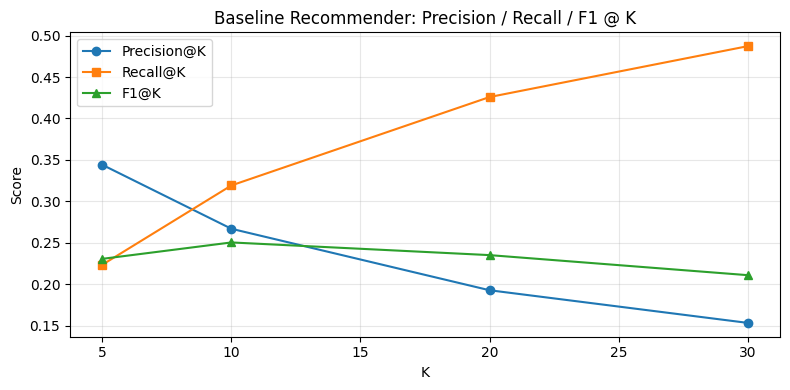

In [12]:
# Visualize Precision / Recall / F1 trade-off
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(results_df['K'], results_df['Precision@K'], 'o-', label='Precision@K')
ax.plot(results_df['K'], results_df['Recall@K'], 's-', label='Recall@K')
ax.plot(results_df['K'], results_df['F1@K'], '^-', label='F1@K')
ax.set_xlabel('K')
ax.set_ylabel('Score')
ax.set_title('Baseline Recommender: Precision / Recall / F1 @ K')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Sample Recommendations

Inspect recommendations for a few users alongside their true next basket.

In [13]:
sample_users = list(ground_truth.keys())[:3]

for uid in sample_users:
    recs = recommend(uid, k=10)
    true = ground_truth[uid]
    rec_names = products.set_index('product_id').loc[recs, 'product_name'].tolist()
    true_names = products.set_index('product_id').loc[list(true), 'product_name'].tolist()
    hits = set(recs) & true

    print(f'\n--- User {uid} ---')
    print(f'  Recommended ({len(recs)}): {rec_names}')
    print(f'  True basket  ({len(true)}): {true_names}')
    print(f'  Hits: {len(hits)}')


--- User 1 ---
  Recommended (10): ['Soda', 'Original Beef Jerky', 'Pistachios', 'Organic String Cheese', 'Cinnamon Toast Crunch', 'Zero Calorie Cola', 'Bag of Organic Bananas', 'Aged White Cheddar Popcorn', 'XL Pick-A-Size Paper Towel Rolls', 'Organic Half & Half']
  True basket  (11): ['Soda', 'XL Pick-A-Size Paper Towel Rolls', 'Organic Whole Milk', 'Zero Calorie Cola', 'Cinnamon Toast Crunch', 'Milk Chocolate Almonds', 'Aged White Cheddar Popcorn', 'Organic String Cheese', '0% Greek Strained Yogurt', 'Pistachios', 'Organic Half & Half']
  Hits: 8

--- User 2 ---
  Recommended (10): ['Chipotle Beef & Pork Realstick', 'Organic Hass Avocado', 'Banana', 'Cherry Pomegranate Greek Yogurt', 'Total 2% All Natural Greek Strained Yogurt with Honey', 'Fat Free Blueberry Yogurt', 'Baked Organic Sea Salt Crunchy Pea Snack', 'Plantain Chips', 'Total 2% with Strawberry Lowfat Greek Strained Yogurt', 'The \\"World\'s Best\\" Veggie Burger']
  True basket  (31): ['Unsweetened Almondmilk', 'Shelled